# Exploratory Data Analysis - 2: Bivariate Analysis, Feature Engineering and Missing Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
train_df = pd.read_csv(
    "data/train.csv", parse_dates=["Scheduled Date", "Delivery Date"]
)

<IPython.core.display.Javascript object>

## Treating Missing Data

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6500 entries, 0 to 6499
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Customer Id            6500 non-null   object        
 1   Artist Name            6500 non-null   object        
 2   Artist Reputation      5750 non-null   float64       
 3   Height                 6125 non-null   float64       
 4   Width                  5916 non-null   float64       
 5   Weight                 5913 non-null   float64       
 6   Material               5736 non-null   object        
 7   Price Of Sculpture     6500 non-null   float64       
 8   Base Shipping Price    6500 non-null   float64       
 9   International          6500 non-null   object        
 10  Express Shipment       6500 non-null   object        
 11  Installation Included  6500 non-null   object        
 12  Transport              5108 non-null   object        
 13  Fra

<IPython.core.display.Javascript object>

We can immediately identify some of the missing columns as:
* `Artist Reputation`
* `Height`
* `Width`
* `Weight`
* `Material`
* `Transport`
* `Remote Location`

Missing values "can have a significant effect on the conclusions that can be drawn from the data" [1]. We need to figure out whether to drop these or imputate them based on how they can impact the results drawn by our model.

This article Towards Data Science [2], explains the different ways the data can be missing. These are:
1. Missing at random - there is a systematic relationship between the propensity of missing values and the observed data, but not the missing data
2. Missing Completely at Random - no relationship between the missingness of the data and any values, observed or missing
3. Missing Not at Random - data is missing is related to the unobserved data

### Univariate Analysis of Missing data wrt Target variable

The easiest to do is to check if there's a relationship between the missing values itself and the target variable

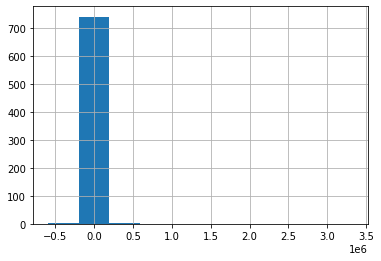

<IPython.core.display.Javascript object>

In [4]:
plt.hist(train_df.loc[train_df["Artist Reputation"].isna(), "Cost"])
plt.grid()
plt.show()

Most of Cost seem to be distributed around 0, but this is also the cast with the non-missing values. Hence there's no relationship here.

In [5]:
train_df.loc[train_df["Artist Reputation"].isna(), "Cost"].describe(
    percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
)

count    7.500000e+02
mean     1.555013e+04
std      1.800113e+05
min     -5.881832e+05
10%      7.884600e+01
25%      1.824700e+02
50%      3.659600e+02
75%      1.167327e+03
90%      5.173631e+03
95%      1.786683e+04
99%      2.145674e+05
max      3.324867e+06
Name: Cost, dtype: float64

<IPython.core.display.Javascript object>

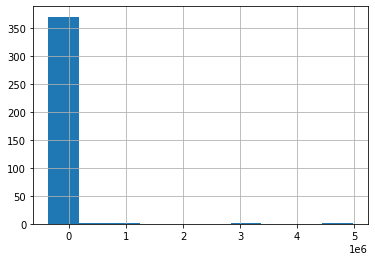

<IPython.core.display.Javascript object>

In [6]:
plt.hist(train_df.loc[train_df["Height"].isna(), "Cost"])
plt.grid()
plt.show()

In [7]:
train_df.loc[train_df["Height"].isna(), "Cost"].describe(
    percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
)

count    3.750000e+02
mean     2.731979e+04
std      3.153483e+05
min     -3.608145e+05
10%      1.159240e+02
25%      1.882250e+02
50%      3.916100e+02
75%      1.195765e+03
90%      5.949440e+03
95%      1.713534e+04
99%      2.149380e+05
max      4.976101e+06
Name: Cost, dtype: float64

<IPython.core.display.Javascript object>

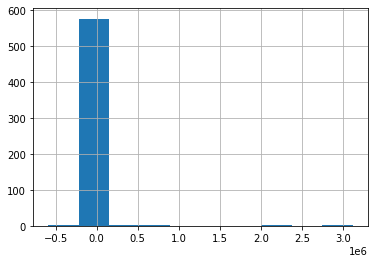

<IPython.core.display.Javascript object>

In [8]:
plt.hist(train_df.loc[train_df["Width"].isna(), "Cost"])
plt.grid()
plt.show()

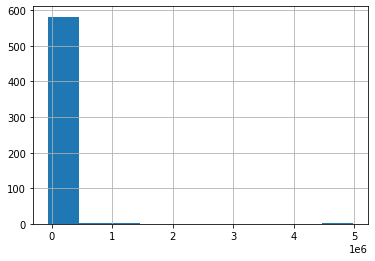

<IPython.core.display.Javascript object>

In [9]:
plt.hist(train_df.loc[train_df["Weight"].isna(), "Cost"])
plt.grid()
plt.show()

In [10]:
train_df.loc[train_df["Weight"].isna(), "Cost"].describe(
    percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
)

count    5.870000e+02
mean     1.768451e+04
std      2.197743e+05
min     -5.766298e+04
10%     -1.590600e+02
25%      1.875200e+02
50%      3.657300e+02
75%      1.118590e+03
90%      5.019574e+03
95%      1.680177e+04
99%      1.602159e+05
max      4.976101e+06
Name: Cost, dtype: float64

<IPython.core.display.Javascript object>

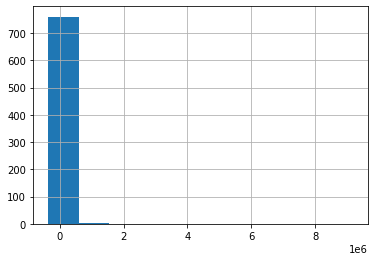

<IPython.core.display.Javascript object>

In [11]:
plt.hist(train_df.loc[train_df["Material"].isna(), "Cost"])
plt.grid()
plt.show()

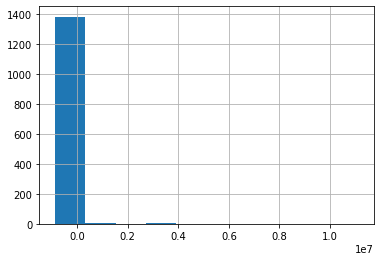

<IPython.core.display.Javascript object>

In [12]:
plt.hist(train_df.loc[train_df["Transport"].isna(), "Cost"])
plt.grid()
plt.show()

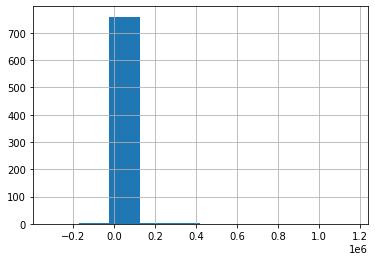

<IPython.core.display.Javascript object>

In [13]:
plt.hist(train_df.loc[train_df["Remote Location"].isna(), "Cost"])
plt.grid()
plt.show()

There seems to be no apparent relationship with the missing variables values and the target variable "Cost".

### `Artist Reputation`

In [14]:
train_df["Artist Reputation"].isna().sum()

750

<IPython.core.display.Javascript object>

There are 750 rows with missing Artist Reputations. We can fill this up using information based on these columns:
1. `Price Of Sculpture`
2. `Base Shipping Price`

Neither of these columns have any NA values. We can use `RandomForests` to fill the NAs.

**To-Do**:
- [ ] Create a cross validating set with rows corresponding to the non-missing data
- [ ] Use evaluatation metrics to find best hyperparameters to fit `RandomForestRegressor`
- [ ] Fit `RandomForestRegressor` with rows corresponding to the missing data

In [15]:
artist_rep_train_df = train_df.loc[
    ~train_df["Artist Reputation"].isna(),
    ["Artist Reputation", "Price Of Sculpture", "Base Shipping Price"],
]

<IPython.core.display.Javascript object>

In [16]:
artist_rep_na_val_regr = RandomForestRegressor(max_depth=2, random_state=0)

<IPython.core.display.Javascript object>

In [17]:
artist_rep_na_val_regr.fit(
    artist_rep_train_df[["Price Of Sculpture", "Base Shipping Price"]],
    artist_rep_train_df["Artist Reputation"],
)

RandomForestRegressor(max_depth=2, random_state=0)

<IPython.core.display.Javascript object>

## Correlation Plots

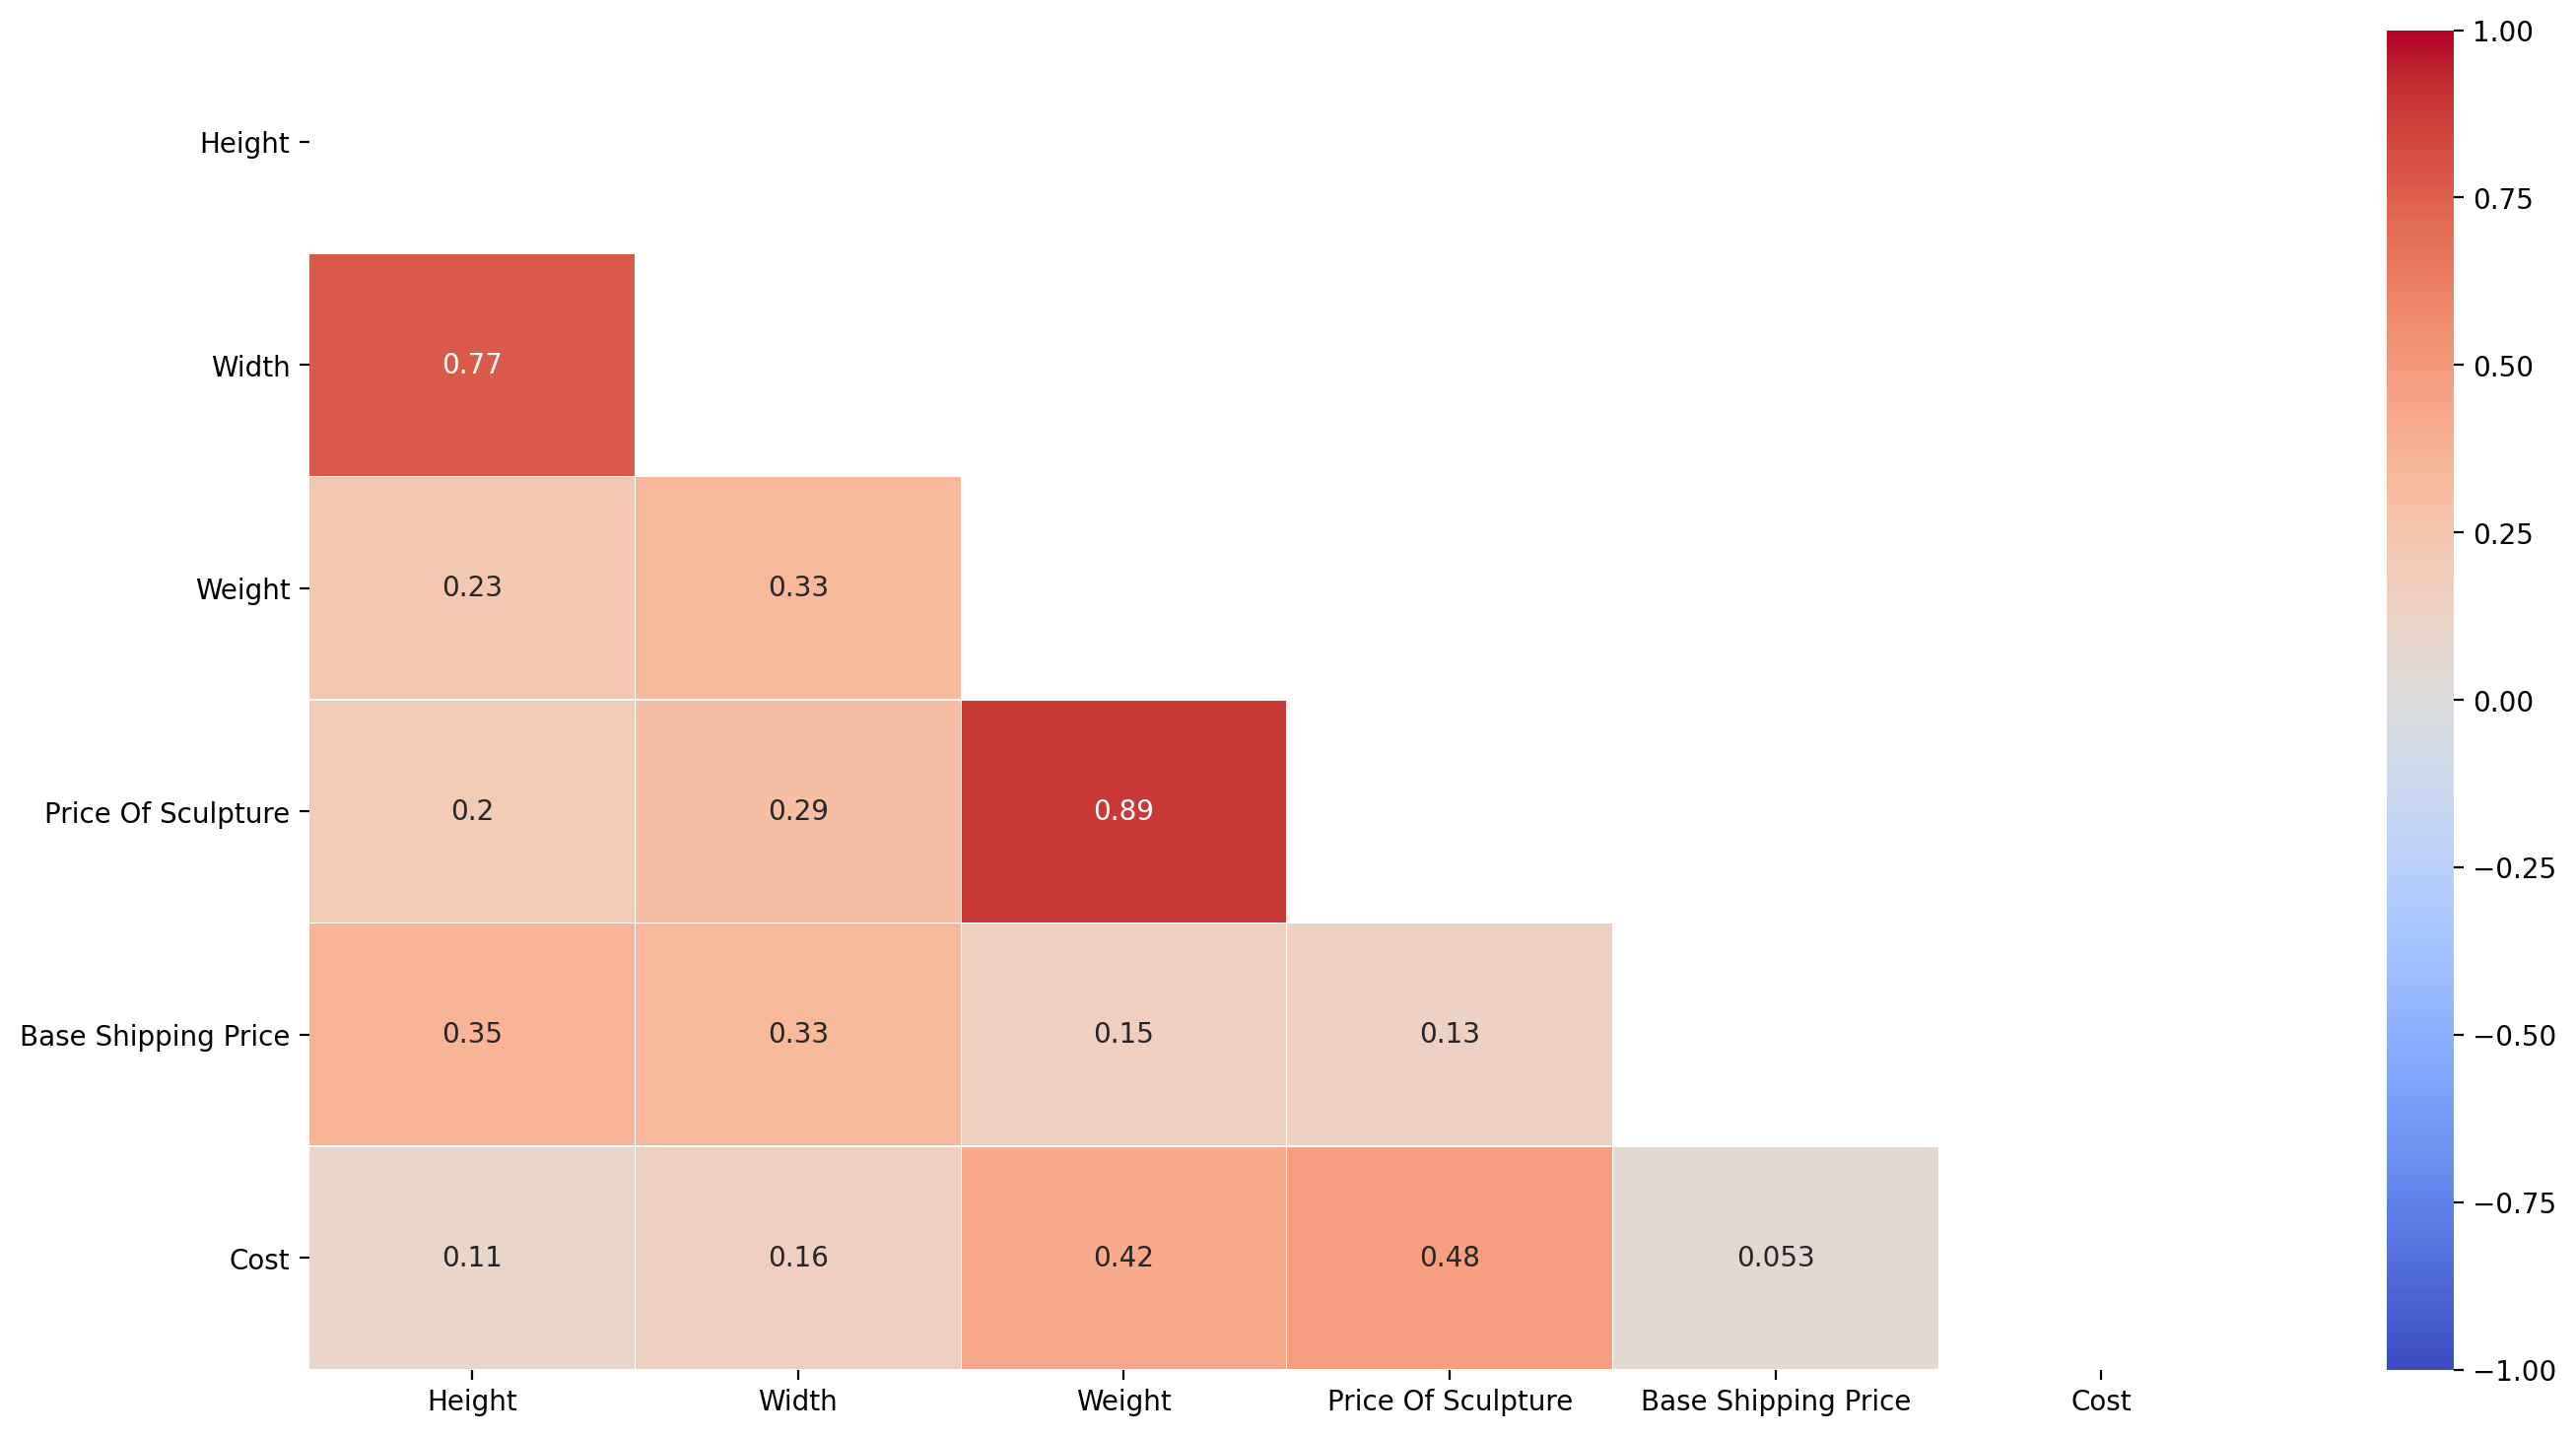

<IPython.core.display.Javascript object>

In [18]:
plt.figure(figsize=(16, 9), dpi=200)
corr_plot = train_df[
    ["Height", "Width", "Weight", "Price Of Sculpture", "Base Shipping Price", "Cost"]
].corr()
mask = np.zeros_like(corr_plot, dtype=bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(
    corr_plot,
    square=False,
    linewidth=0.1,
    vmin=-1,
    vmax=1,
    cmap="coolwarm",
    annot=True,
    mask=mask,
)
plt.show()

The following variables are correlated, based on their coefficient of correlation:
1. Height and Width
2. Weight and Price of Sculpture

We can combine height and width in order to get area.

In [19]:
train_df["Area"] = train_df["Height"] * train_df["Width"]

<IPython.core.display.Javascript object>

Similarly Weight and Price of Sculpture can be combined to get price per unit weight

In [20]:
train_df["Price per unit weight"] = train_df["Price Of Sculpture"] / train_df["Weight"]

<IPython.core.display.Javascript object>

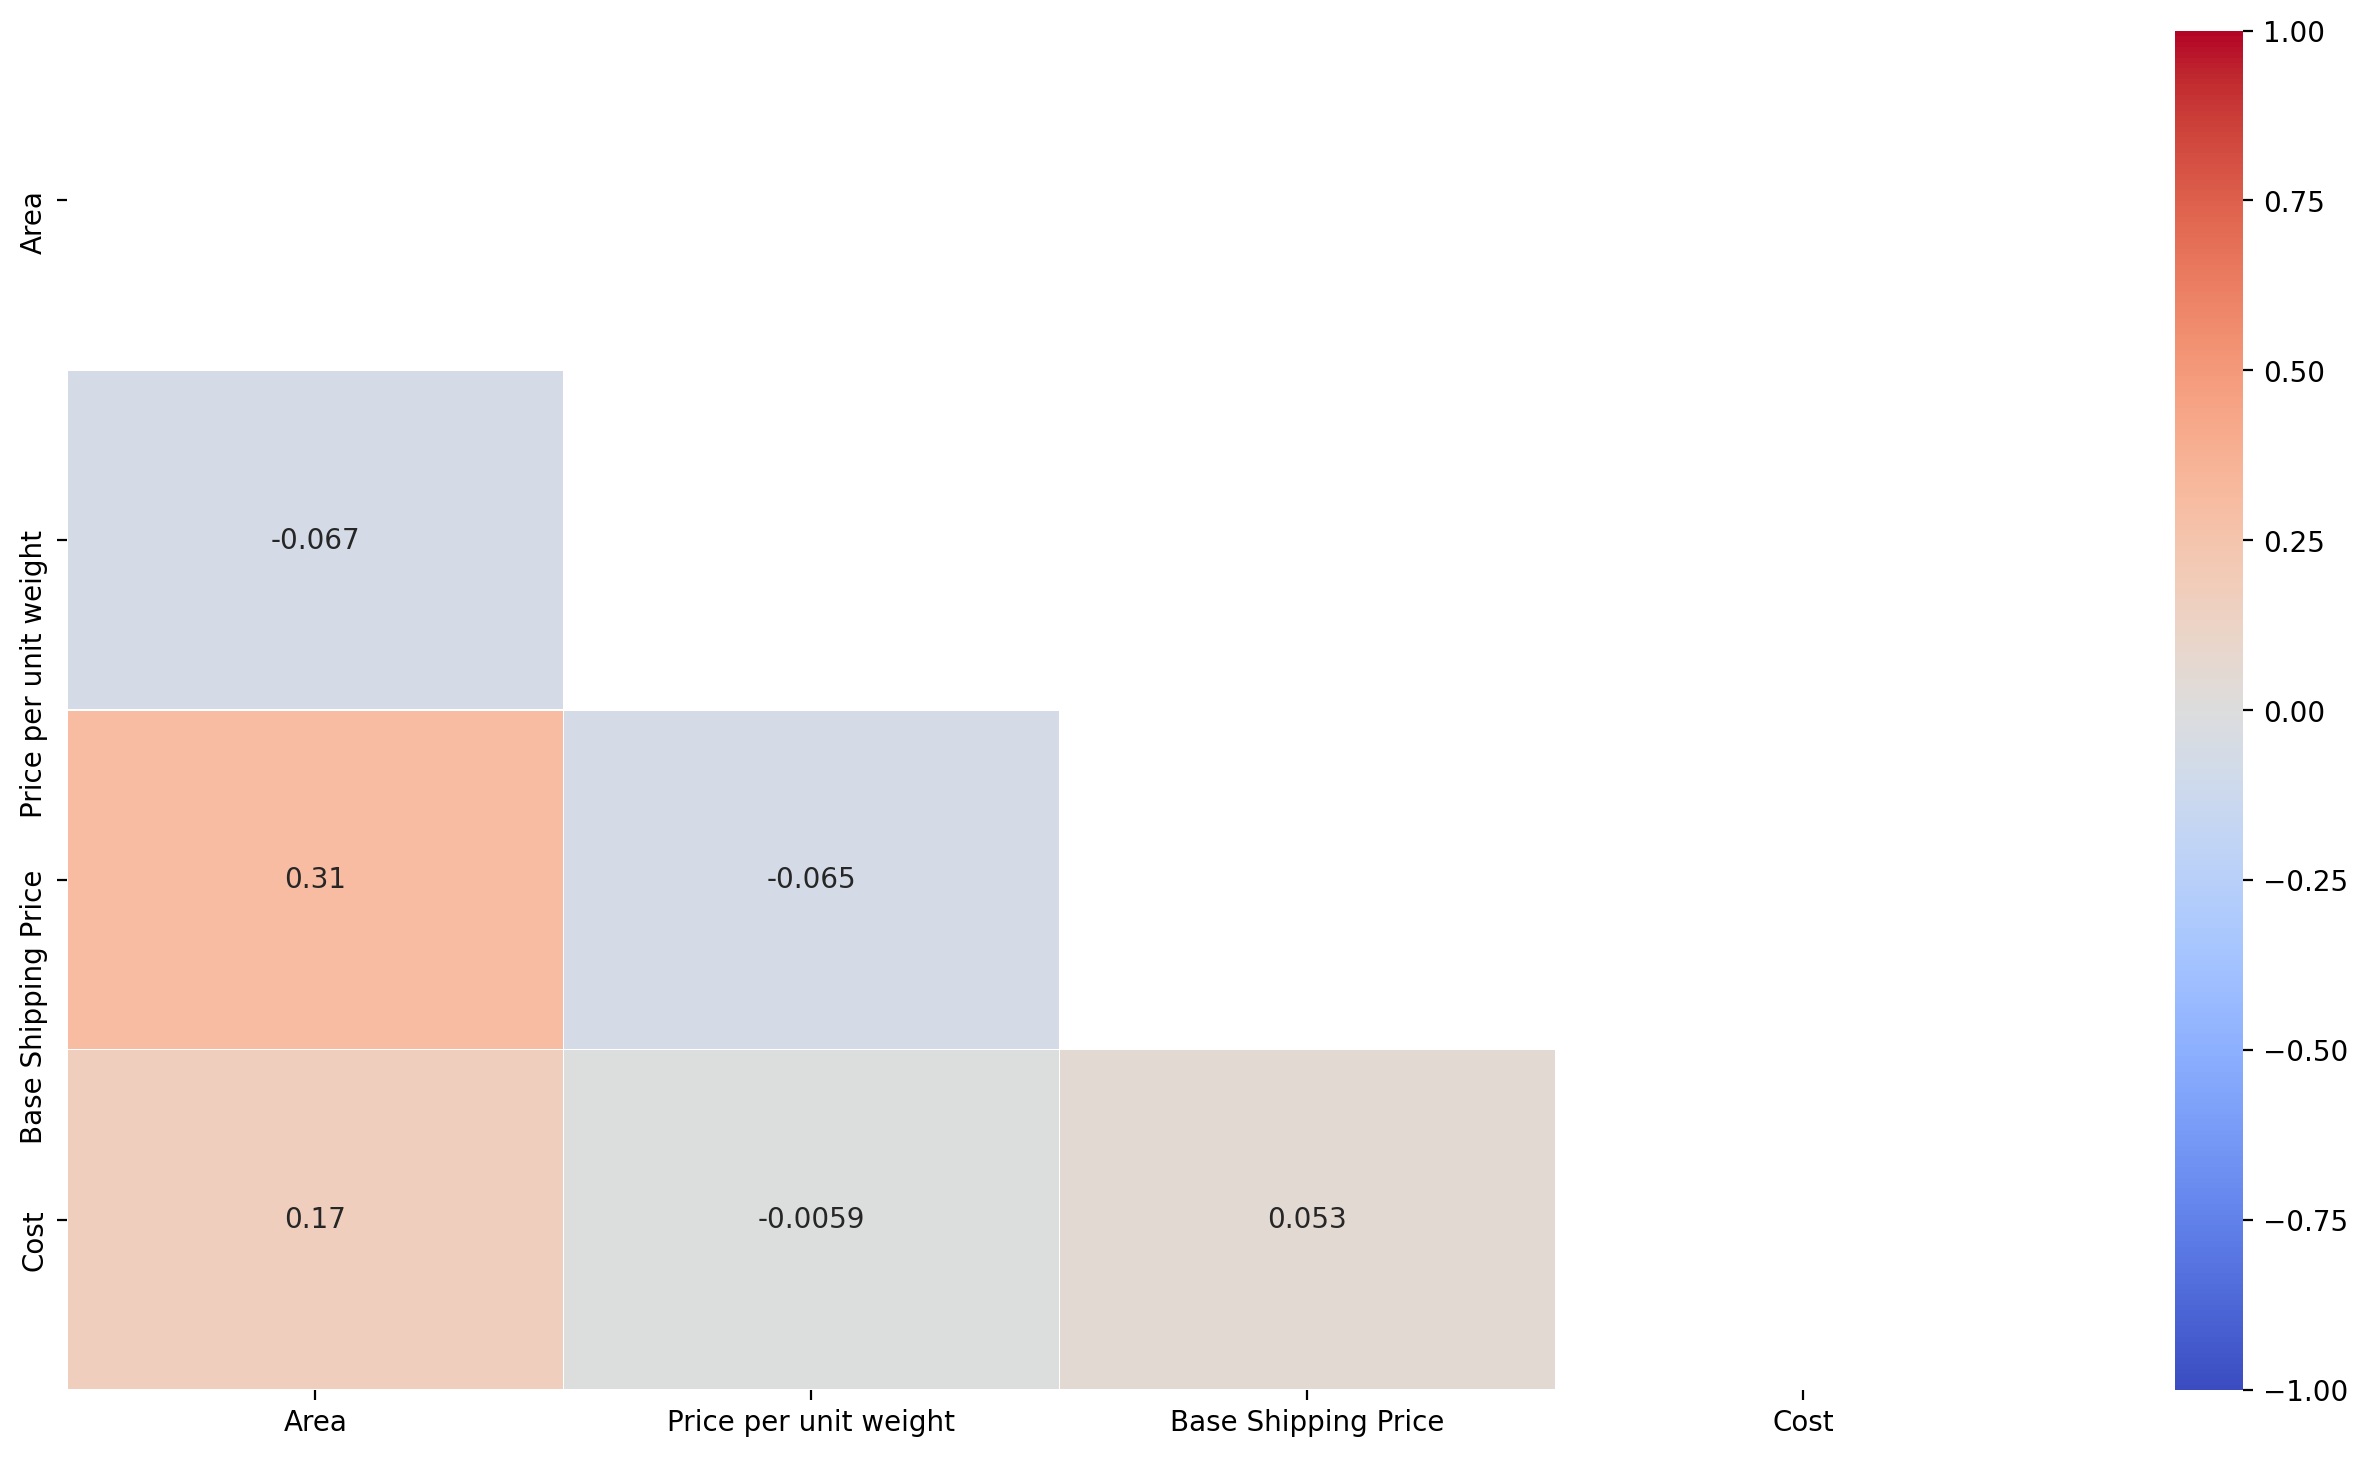

<IPython.core.display.Javascript object>

In [21]:
plt.figure(figsize=(16, 9), dpi=200)
corr_plot = train_df[
    ["Area", "Price per unit weight", "Base Shipping Price", "Cost"]
].corr()
mask = np.zeros_like(corr_plot, dtype=bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(
    corr_plot,
    square=False,
    linewidth=0.1,
    vmin=-1,
    vmax=1,
    cmap="coolwarm",
    annot=True,
    mask=mask,
)
plt.show()

## References

1. [The prevention and handling of the missing data](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3668100/)
2. [How to Handle Missing Data](https://towardsdatascience.com/how-to-handle-missing-data-8646b18db0d4)